In [3]:
from copy import deepcopy

import numpy as np
import torch
import tensorly as tl
import matplotlib.pyplot as plt
import torchvision
from tensorly.decomposition import tucker, parafac
import warnings
import gc
import copy
import torch.nn as nn
import tqdm
from triton.language import dtype

tl.set_backend("pytorch")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
in_channels = 64
out_channels = 128
kernel_size = (4, 4)
tensor_size = 7
number_of_images = 16

In [ ]:
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', 'DCGAN', pretrained=True, useGPU=device)
model_compressed = copy.deepcopy(model)
model_replaced = copy.deepcopy(model)

In [ ]:
testConvTranspose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, dtype=torch.float32).to(device)
random_tensor = torch.randn(number_of_images, in_channels, 1, 1, dtype=torch.float32).to(device)

In [ ]:
# %%timeit -r 10 -n 1000
# testConvTranspose(random_tensor)

In [ ]:
def SVD_conv(conv_layer: torch.nn.ConvTranspose2d, rank_CPD: int = None) -> (torch.nn.Sequential, float):
    out_channels = conv_layer.out_channels
    in_channels = conv_layer.in_channels
    stride = conv_layer.stride
    bias = conv_layer.bias is not None
    matrix = conv_layer.weight.squeeze().squeeze()
    if rank_CPD is None:
        rank_CPD = min(matrix.shape)

    core, factors = parafac(matrix, rank_CPD, init="random")
    norm = tl.norm(matrix - tl.cp_to_tensor((core, factors))) / tl.norm(matrix)
    print(f"SVD ({in_channels}, {out_channels}, (1, 1)): {norm}")

    factor_CPD_input = factors[1].permute([1, 0]).unsqueeze(2).unsqueeze(3)
    factor_CPD_output = factors[0].unsqueeze(2).unsqueeze(3)


    conv1 = torch.nn.ConvTranspose2d(in_channels, rank_CPD, 1, stride=stride, dtype=torch.float32, bias=bias)
    conv2 = torch.nn.ConvTranspose2d(rank_CPD, out_channels, 1, dtype=torch.float32, bias=bias)
    conv1.weight = torch.nn.parameter.Parameter(factor_CPD_input)
    conv2.weight = torch.nn.parameter.Parameter(factor_CPD_output)
    return torch.nn.Sequential(conv1, conv2), norm

In [ ]:
def CPD_conv(conv_layer: torch.nn.ConvTranspose2d, rank_CPD: int = None) -> (torch.nn.Sequential, float):
    if conv_layer.kernel_size == (1, 1):
        return SVD_conv(conv_layer, rank_CPD)
    # Params of source conv_layer
    out_channels = conv_layer.out_channels
    in_channels = conv_layer.in_channels
    kernel_size_x = conv_layer.kernel_size[0]
    kernel_size_y = conv_layer.kernel_size[1]
    stride = conv_layer.stride
    padding = conv_layer.padding
    dilation = conv_layer.dilation
    bias = conv_layer.bias is not None
    conv_weight = conv_layer.weight.reshape(in_channels, out_channels, kernel_size_x * kernel_size_y)

    if rank_CPD is None:
        rank_CPD = sorted(conv_weight.size())[0]

    core_CPD, factors_CPD = parafac(conv_weight, rank_CPD, verbose=0)
    norm = tl.norm(conv_weight - tl.cp_to_tensor((core_CPD, factors_CPD))) / tl.norm(conv_weight)
    print(f"CPD ({in_channels}, {out_channels}, ({kernel_size_x}, {kernel_size_y})): {norm}")

    factor_CPD_input = factors_CPD[0].unsqueeze(2).unsqueeze(3)
    factor_CPD_hidden = factors_CPD[2].permute([1, 0]).unsqueeze(1).reshape(rank_CPD, 1, kernel_size_x, kernel_size_y)
    factor_CPD_output = factors_CPD[1].permute([1, 0]).unsqueeze(2).unsqueeze(3)


    conv1_CPD = torch.nn.ConvTranspose2d(in_channels, rank_CPD, 1, dtype=torch.float32, bias=bias)
    conv2_CPD = torch.nn.ConvTranspose2d(rank_CPD, rank_CPD, (kernel_size_x, kernel_size_y), groups=rank_CPD, stride=stride, padding=padding, dilation=dilation, dtype=torch.float32, bias=bias)
    conv3_CPD = torch.nn.ConvTranspose2d(rank_CPD, out_channels, 1, dtype=torch.float32, bias=bias)
    conv1_CPD.weight = torch.nn.parameter.Parameter(factor_CPD_input)
    conv2_CPD.weight = torch.nn.parameter.Parameter(factor_CPD_hidden)
    conv3_CPD.weight = torch.nn.parameter.Parameter(factor_CPD_output)

    return torch.nn.Sequential(conv1_CPD, conv2_CPD, conv3_CPD), norm

In [ ]:
CPD = CPD_conv(testConvTranspose)[0].to(device)

In [ ]:
# %%timeit -r 10 -n 1000
# CPD(random_tensor)

In [ ]:
def TKD_conv(conv_layer: torch.nn.ConvTranspose2d, rank_TKD: list[int]=None) -> (torch.nn.Sequential, float):
    if conv_layer.kernel_size == (1, 1):
        return SVD_conv(conv_layer, min(rank_TKD))
    # Params of source conv_layer
    out_channels = conv_layer.out_channels
    in_channels = conv_layer.in_channels
    kernel_size_x = conv_layer.kernel_size[0]
    kernel_size_y = conv_layer.kernel_size[1]
    stride = conv_layer.stride
    padding = conv_layer.padding
    dilation = conv_layer.dilation
    bias = conv_layer.bias is not None
    conv_weight = conv_layer.weight.reshape(in_channels, out_channels, kernel_size_x * kernel_size_y)

    if rank_TKD is None:
        rank_TKD = [in_channels, out_channels]
    else:
        if rank_TKD[0] > in_channels:
            rank_TKD = (in_channels, rank_TKD[1], rank_TKD[2])
            warnings.warn("rank_TKD[0] is bigger then in_channels")
        if rank_TKD[1] > out_channels:
            rank_TKD = (rank_TKD[0], out_channels, rank_TKD[2])
            warnings.warn("rank_TKD[1] is bigger then out_channels")

    core_TKD, factors_TKD = tucker(conv_weight, rank_TKD + [kernel_size_y * kernel_size_x], verbose=0)
    norm = tl.norm(conv_weight - tl.tucker_to_tensor((core_TKD, factors_TKD))) / tl.norm(conv_weight)
    print(f"TKD ({in_channels}, {out_channels}, ({kernel_size_x}, {kernel_size_y})): {norm}")

    factor_TKD_input = factors_TKD[0].unsqueeze(2).unsqueeze(3)
    factor_TKD_hidden = torch.tensordot(core_TKD, factors_TKD[2], dims=([2], [1])).reshape(rank_TKD[0], rank_TKD[1], kernel_size_x, kernel_size_y)
    factor_TKD_output = factors_TKD[1].permute([1, 0]).unsqueeze(2).unsqueeze(3)

    conv1_TKD = torch.nn.ConvTranspose2d(in_channels, rank_TKD[0], 1, dtype=torch.float32, bias=bias)
    conv2_TKD = torch.nn.ConvTranspose2d(rank_TKD[0], rank_TKD[1], (kernel_size_x, kernel_size_y), stride=stride, padding=padding, dilation=dilation, dtype=torch.float32, bias=bias)
    conv3_TKD = torch.nn.ConvTranspose2d(rank_TKD[1], out_channels, 1, dtype=torch.float32, bias=bias)
    conv1_TKD.weight = torch.nn.parameter.Parameter(factor_TKD_input)
    conv2_TKD.weight = torch.nn.parameter.Parameter(factor_TKD_hidden)
    conv3_TKD.weight = torch.nn.parameter.Parameter(factor_TKD_output)

    return torch.nn.Sequential(conv1_TKD, conv2_TKD, conv3_TKD), norm

In [ ]:
TKD = TKD_conv(testConvTranspose, [32, 64])[0].to(device)

In [ ]:
# %%timeit -r 10 -n 1000
# TKD(random_tensor)

In [ ]:
def TKDCPD_conv(conv_layer: torch.nn.ConvTranspose2d, rank_TKD: list[int] = None, rank_CPD: int = None) -> (torch.nn.Sequential, float):
    if conv_layer.kernel_size == (1, 1):
        return SVD_conv(conv_layer, rank_CPD)
    # Params of source conv_layer
    out_channels = conv_layer.out_channels
    in_channels = conv_layer.in_channels
    kernel_size_x = conv_layer.kernel_size[0]
    kernel_size_y = conv_layer.kernel_size[1]
    stride = conv_layer.stride
    padding = conv_layer.padding
    dilation = conv_layer.dilation
    bias = conv_layer.bias is not None
    conv_weight = conv_layer.weight.reshape(in_channels, out_channels, kernel_size_x * kernel_size_y)

    if rank_TKD is None:
        rank_TKD = [in_channels, out_channels]
    else:
        if rank_TKD[0] > in_channels:
            rank_TKD = (in_channels, rank_TKD[1], rank_TKD[2])
            warnings.warn(f"rank_TKD[0] is bigger then in_channels\n\nrank_TKD[0]={rank_TKD[0]}\nin_channels={in_channels}")
        if rank_TKD[1] > out_channels:
            rank_TKD = (rank_TKD[0], out_channels, rank_TKD[2])
            warnings.warn(f"rank_TKD[1] is bigger then out_channels\n\nrank_TKD[1]={rank_TKD[1]}\nout_channels={in_channels}")

    core_TKD, factors_TKD = tucker(conv_weight, rank_TKD + [kernel_size_x * kernel_size_y], verbose=0)
    norm = tl.norm(conv_weight - tl.tucker_to_tensor((core_TKD, factors_TKD))) / tl.norm(conv_weight)
    print(f"TKDCPD ({in_channels}, {out_channels}, ({kernel_size_x}, {kernel_size_y})): {norm}")

    factor_TKD_input = factors_TKD[0].unsqueeze(2).unsqueeze(3)
    factor_TKD_hidden = torch.tensordot(core_TKD, factors_TKD[2], dims=([2], [1])).permute([1, 2, 0]).reshape(rank_TKD[0], rank_TKD[1], kernel_size_x, kernel_size_y)
    factor_TKD_output = factors_TKD[1].permute([1, 0]).unsqueeze(2).unsqueeze(3)

    conv2_TKD = torch.nn.ConvTranspose2d(rank_TKD[0], rank_TKD[1], (kernel_size_x, kernel_size_y), stride=stride, padding=padding, dilation=dilation, dtype=torch.float32, bias=bias)
    conv2_TKD.weight = torch.nn.parameter.Parameter(factor_TKD_hidden)
    conv2_TKD = CPD_conv(conv2_TKD, rank_CPD=rank_CPD)
    norm = conv2_TKD[1]
    conv2_TKD = conv2_TKD[0]

    conv1_TKD = torch.nn.ConvTranspose2d(in_channels, rank_TKD[0], 1, dtype=torch.float32, bias=bias)
    conv3_TKD = torch.nn.ConvTranspose2d(rank_TKD[1], out_channels, 1, dtype=torch.float32, bias=bias)
    conv1_TKD.weight = torch.nn.parameter.Parameter(factor_TKD_input)
    conv3_TKD.weight = torch.nn.parameter.Parameter(factor_TKD_output)

    return torch.nn.Sequential(conv1_TKD, conv2_TKD, conv3_TKD), norm

In [ ]:
TKDCPD = TKDCPD_conv(testConvTranspose)[0].to(device)

In [ ]:
# %%timeit -r 10 -n 1000
# TKDCPD(random_tensor)

# Compress

In [ ]:
def replace_deconv_layers(module, conv_func):
    for name, child in module.named_children():
        # If child is a ConvTranspose2d, replace it with a new layer
        if isinstance(child, nn.ConvTranspose2d):
            weight = child.weight.size()
            if weight[1] == 3:
                continue
            TKD, _ = conv_func(child, [weight[0] // 4, weight[1] // 4, weight[2] * weight[3]])
            setattr(module, name, TKD)
        else:
            # Recursively process nested submodules (for custom blocks)
            replace_deconv_layers(child, conv_func)

In [ ]:
replace_deconv_layers(model_compressed.netG, TKDCPD_conv)

##### Photo 1

In [ ]:
num_images = 64
clean_noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(clean_noise)

# let's plot these images using torchvision and matplotlib

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

In [ ]:
num_images = 64
with torch.no_grad():
    generated_images = model_compressed.test(clean_noise)

# let's plot these images using torchvision and matplotlib

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

## TRAIN

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 120
num_samples = 10000
batch_size = 64

# Generate random noise as inputs
def generate_random_noise(batch_size, latent_dim):
    return torch.randn(batch_size, latent_dim, 1, 1).to(device)


In [ ]:
# Load the original model (teacher)
teacher = model
teacher.netG.eval()

# Load your modified model (student)
student = model_compressed  # Replace with your modified model definition
student.netG.train()

In [ ]:
loss_fn = nn.MSELoss()  # Loss function to match the outputs

optimizer = torch.optim.Adam(student.netG.parameters())

In [ ]:
epochs = 20

for epoch in range(epochs):
    for _ in tqdm.tqdm(range(num_samples // batch_size)):
        # Generate random noise
        noise = generate_random_noise(batch_size, latent_dim)

        # Get teacher outputs
        with torch.no_grad():  # No gradients needed for the teacher
            teacher_outputs = teacher.netG(noise)

        # Get student outputs
        student_outputs = student.netG(noise)

        # Compute loss
        loss = loss_fn(student_outputs, teacher_outputs)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


##### Photo 2

In [ ]:
model_compressed = student
num_images = 64
with torch.no_grad():
    generated_images = model_compressed.test(clean_noise)

# let's plot these images using torchvision and matplotlib

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

# Replace

In [ ]:
## Convert RESNET
def replace_model(resnet):
    layer_norms = {}
    for name, module in resnet.named_modules():
        if isinstance(module, torch.nn.ConvTranspose2d):
            parent_name = ".".join(name.split(".")[:-1])
            attr_name = name.split(".")[-1]
            print(parent_name, end=": ")
            # Access the parent module
            parent_module = resnet
            if parent_name:
                parent_module = dict(resnet.named_modules())[parent_name]

            # Replace the old layer with the new one
            weights = module.weight.size()
            if weights[1] == 3:
                continue
            result = nn.Sequential(nn.ConvTranspose2d(weights[0], weights[0] // 2, kernel_size=1, bias=False),
                                   nn.ConvTranspose2d(weights[0] // 2, weights[1] // 2, kernel_size=(weights[2], weights[3]), stride=module.stride, padding=module.padding, bias=False),
                                   nn.ConvTranspose2d(weights[1] // 2, weights[1], kernel_size=1, bias=False))
            setattr(parent_module, attr_name, result)
            del result
            gc.collect()
            torch.cuda.empty_cache()
    return resnet

In [ ]:
model_replaced_G = replace_model(model_replaced.getNetG())

In [ ]:
model_replaced.netG = nn.DataParallel(model_replaced_G)
num_images = 64
with torch.no_grad():
    generated_images = model_replaced.test(clean_noise)

# let's plot these images using torchvision and matplotlib

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

## TRAIN

In [ ]:
latent_dim = 120
num_samples = 10000
batch_size = 64


# Generate random noise as inputs
def generate_random_noise(batch_size, latent_dim):
    return torch.randn(batch_size, latent_dim, 1, 1).to(device)

In [ ]:
# Load the original model (teacher)
teacher = model
teacher.netG.eval()

# Load your modified model (student)
student = model_replaced  # Replace with your modified model definition
student.netG.train()

In [ ]:
loss_fn = nn.MSELoss()  # Loss function to match the outputs

optimizer = torch.optim.Adam(student.netG.parameters())

In [ ]:
for epoch in range(epochs):
    for _ in tqdm.tqdm(range(num_samples // batch_size)):
        # Generate random noise
        noise = generate_random_noise(batch_size, latent_dim)

        # Get teacher outputs
        with torch.no_grad():  # No gradients needed for the teacher
            teacher_outputs = teacher.netG(noise)

        # Get student outputs
        student_outputs = student.netG(noise)

        # Compute loss
        loss = loss_fn(student_outputs, teacher_outputs)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

##### Photo 3

In [ ]:
model_replaced = student
num_images = 64
with torch.no_grad():
    generated_images = model_replaced.test(clean_noise)

# let's plot these images using torchvision and matplotlib

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

In [ ]:
model_replaced.netG

In [ ]:
# %%timeit -r 10 -n 1000
# model_compressed.netG(clean_noise)

In [ ]:
# %%timeit -r 10 -n 1000
# model.netG(clean_noise)

# TEST

## Random Tensor

In [ ]:
random_tensor = torch.randn(100, 50, 25, 10).to(device)

## Decomposition

In [ ]:
core, factors = tucker(random_tensor, rank=[100, 50, 25, 10])

In [ ]:
factors[0].size()

## Manual Restore

In [ ]:
factor1 = torch.tensordot(core, factors[0], dims=([0], [1]))
print(factor1.shape)
factor2 = torch.tensordot(factor1, factors[1], dims=([0], [1]))
print(factor2.shape)
factor3 = torch.tensordot(factor2, factors[2], dims=([0], [1]))
print(factor3.shape)
factor4 = torch.tensordot(factor3, factors[3], dims=([0], [1]))
print(factor4.shape)

## Compare manual restore vs built-it restore

In [ ]:
print(tl.norm(random_tensor - factor4) / tl.norm(random_tensor))
print(tl.norm(random_tensor - tl.tucker_to_tensor((core, factors))) / tl.norm(random_tensor))
print(torch.sum(factor4 - tl.tucker_to_tensor((core, factors))))

## Test small conv

In [ ]:
def replace_deconv_layers(module):
    for name, child in module.named_children():
        # If child is a ConvTranspose2d, replace it with a new layer
        if isinstance(child, nn.ConvTranspose2d):
            weight = child.weight.size()
            if weight[1] == 3:
                continue
            TKD, _ = TKD_conv(child, [weight[0] // 4, weight[1] // 4, weight[2] * weight[3]])
            setattr(module, name, TKD)
        else:
            # Recursively process nested submodules (for custom blocks)
            replace_deconv_layers(child)

model_compressed = deepcopy(model.netG)
replace_deconv_layers(model_compressed)

In [ ]:
tensor = torch.randn(64, 120, 1, 1).to(device)
tensor_decomposed = deepcopy(tensor)

In [ ]:
tensor = model.netG(tensor)
tensor_decomposed = model_compressed(tensor_decomposed)

In [ ]:
model.netG

In [ ]:
grid = torchvision.utils.make_grid(tensor.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

In [ ]:
grid = torchvision.utils.make_grid(tensor_decomposed.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

In [ ]:
torch.mean(tensor - tensor_decomposed)

In [1]:
from src.model_compressor.model_compressor import *
import torch
import torchvision
import matplotlib.pyplot as plt
from copy import deepcopy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
gan = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', 'DCGAN', pretrained=True, useGPU=False)

Average network found !


Using cache found in /home/aleksandr-vashchenko/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


In [3]:
model = deepcopy(gan.netG)

In [4]:
compress_model(model, conv_transpose_compression_method="TKD", finetune=True, optimizer=torch.optim.Adam, loss_function=torch.nn.MSELoss, data_size=[120, 1, 1], batch_size=256, finetune_device=device, target_compression_ratio=1.0)

differential_evolution step 1: f(x)= 0.5251731255915429
differential_evolution step 2: f(x)= 0.5251731255915429
differential_evolution step 3: f(x)= 0.5243102476871055
differential_evolution step 4: f(x)= 0.5242871757225237
Polishing solution with 'L-BFGS-B'
11.051497917000233
[np.int64(23), np.int64(200), np.int64(16)]
differential_evolution step 1: f(x)= 0.8049417401887476
differential_evolution step 2: f(x)= 0.803253550873138
differential_evolution step 3: f(x)= 0.8029105182029307
Polishing solution with 'L-BFGS-B'
12.932852408999679
[np.int64(88), np.int64(106), np.int64(16)]
differential_evolution step 1: f(x)= 0.8293258707262575
differential_evolution step 2: f(x)= 0.8291651869416237
Polishing solution with 'L-BFGS-B'
4.540026317999946
[np.int64(53), np.int64(38), np.int64(16)]
differential_evolution step 1: f(x)= 0.7554339660555125
differential_evolution step 2: f(x)= 0.7470315976291895
differential_evolution step 3: f(x)= 0.7463161597251892
Polishing solution with 'L-BFGS-B'
3.

In [5]:
random_tensor = torch.randn(64, 120, 1, 1)

In [6]:
model.cpu()
out1 = model(random_tensor)

In [7]:
gan.netG.cpu()
out2 = gan.netG(random_tensor)

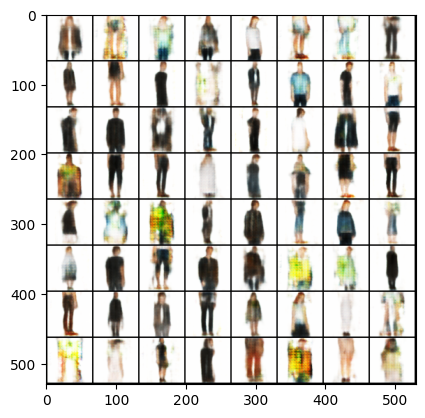

In [8]:
grid = torchvision.utils.make_grid(out1.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

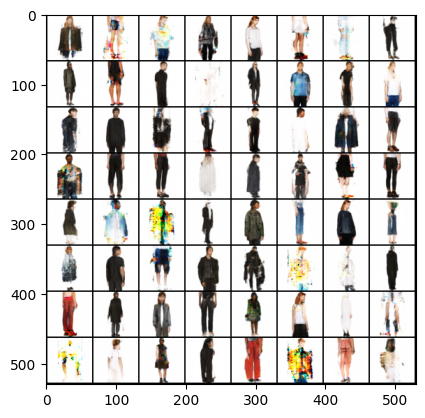

In [9]:
grid = torchvision.utils.make_grid(out2.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

In [10]:
model

GNet(
  (formatLayer): Sequential(
    (0): ConvTranspose2d(120, 23, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): ConvTranspose2d(23, 200, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (2): ConvTranspose2d(200, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (main): Sequential(
    (batchNorm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (convTranspose1): Sequential(
      (0): ConvTranspose2d(512, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): ConvTranspose2d(88, 106, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (2): ConvTranspose2d(106, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (batchNorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (convTranspose2): Sequential(
      (0): ConvTranspose2d(256, 53, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1):

In [11]:
gan.netG

GNet(
  (formatLayer): ConvTranspose2d(120, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (main): Sequential(
    (batchNorm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (convTranspose1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (convTranspose2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (convTranspose3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (outlayer): ConvTranspo

In [12]:
random_tensor = random_tensor.to(device)
model = model.to(device)
gan.netG = gan.netG.to(device)

In [13]:
%%timeit -r 10 -n 100
with torch.no_grad():
    with torch.amp.autocast("cuda", dtype=torch.float16, enabled=True):
        model(random_tensor)

855 μs ± 291 μs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [14]:
%%timeit -r 10 -n 100
with torch.no_grad():
    with torch.amp.autocast("cuda", dtype=torch.float16, enabled=True):
        gan.netG(random_tensor)

1 ms ± 60.3 μs per loop (mean ± std. dev. of 10 runs, 100 loops each)
